C:\Users\aidan\AppData\Local\Temp\ipykernel_4484\208306784.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataModel = pd.read_sql_query(query, conn)


Analyseren van 8 productgroepen (zonder Diverse producten en Lickbits).
-: Train R²=0.846, Test R²=0.759, Train MAE=539.6, Test MAE=982.3


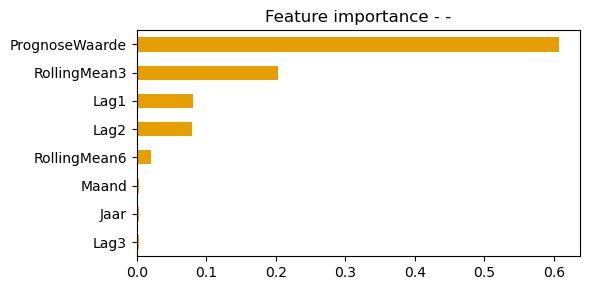

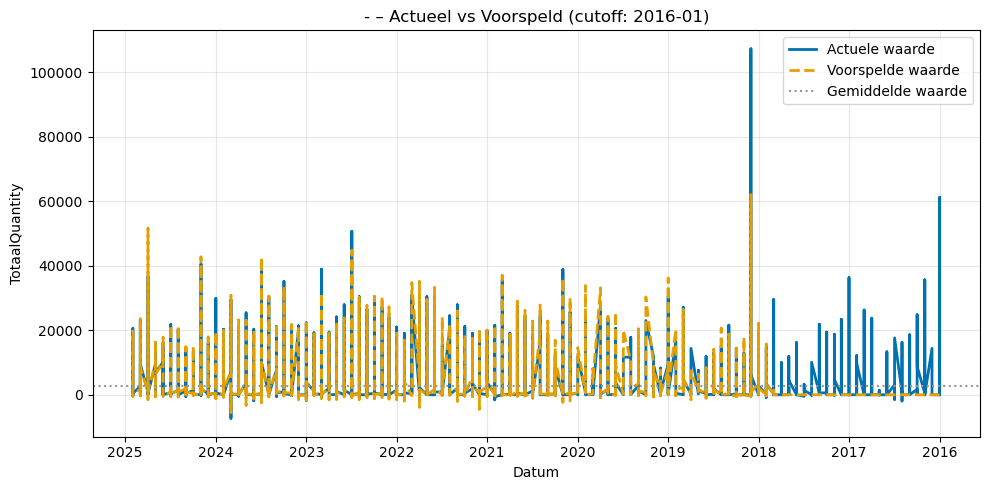

Gevulde producten: Train R²=0.698, Test R²=0.827, Train MAE=832.7, Test MAE=872.2


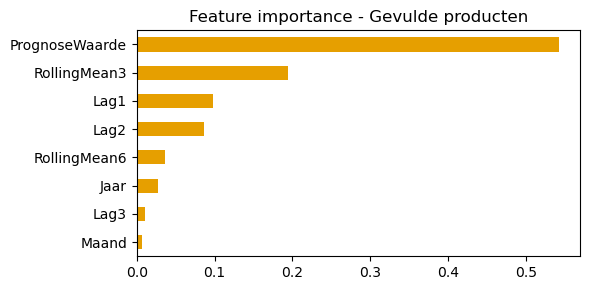

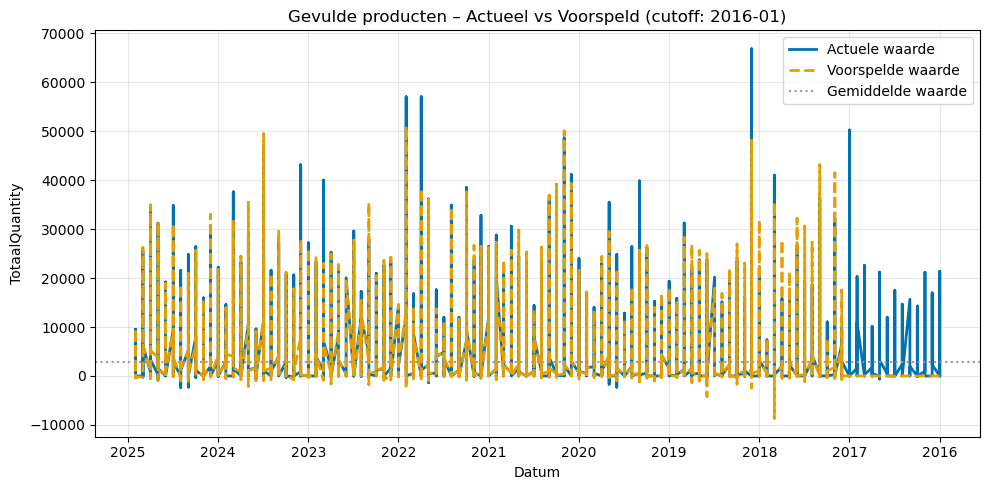

Keelverzorgers: Train R²=0.791, Test R²=0.808, Train MAE=1513.8, Test MAE=1688.9


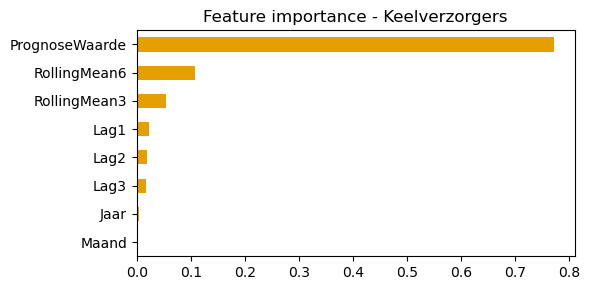

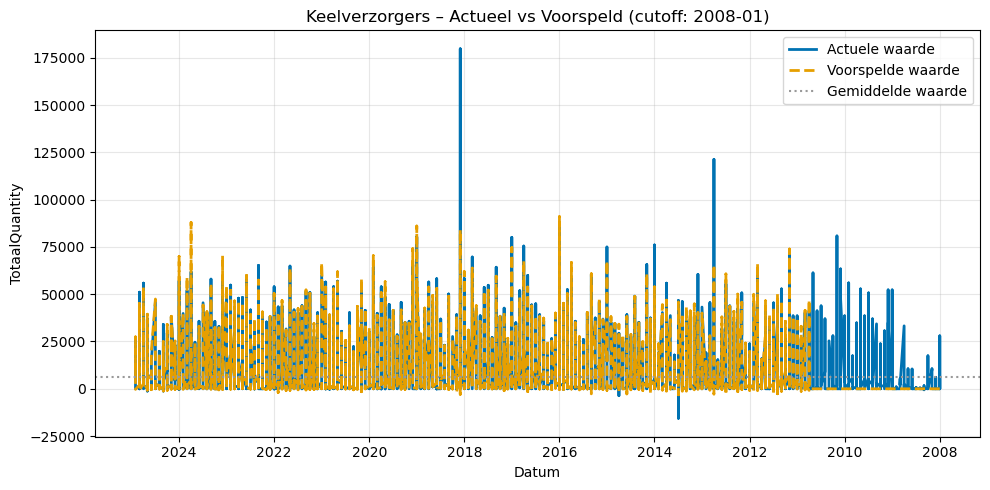

Lolly's: Train R²=0.792, Test R²=0.689, Train MAE=307.5, Test MAE=494.5


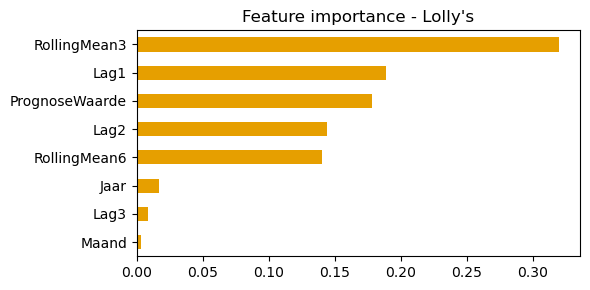

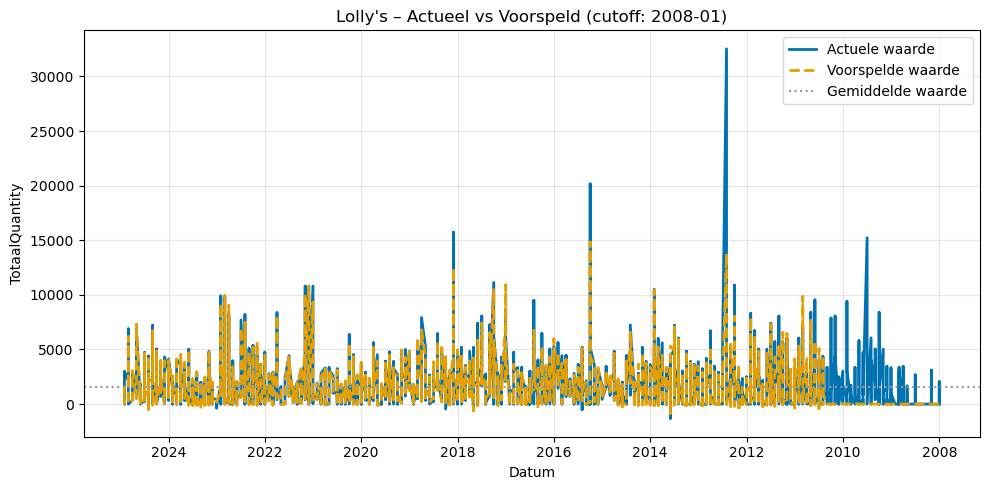

Napoleon kogels: Train R²=0.723, Test R²=0.705, Train MAE=661.8, Test MAE=938.6


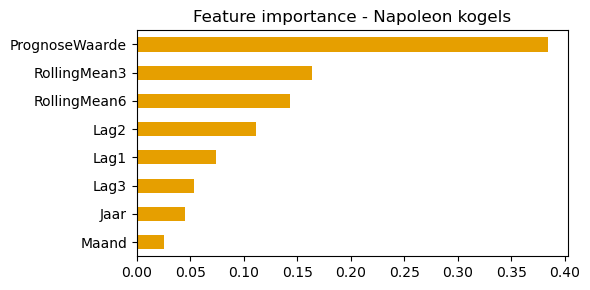

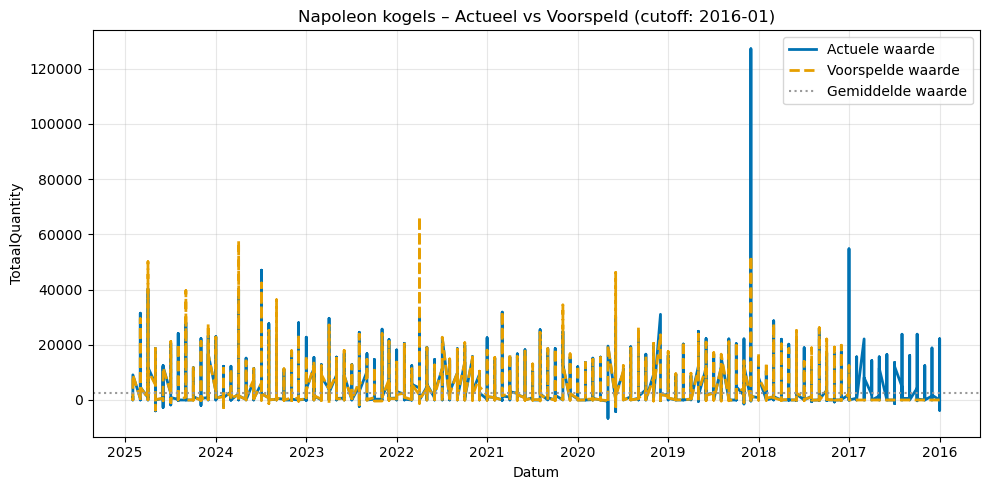

Ongevulde producten: Train R²=0.809, Test R²=0.744, Train MAE=557.0, Test MAE=667.5


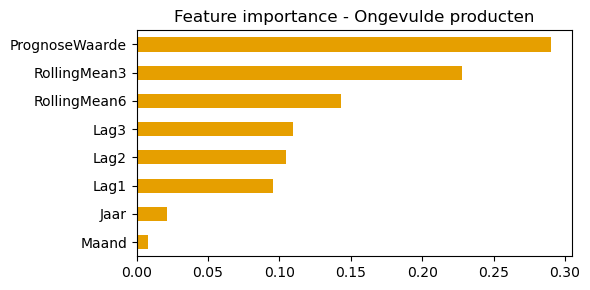

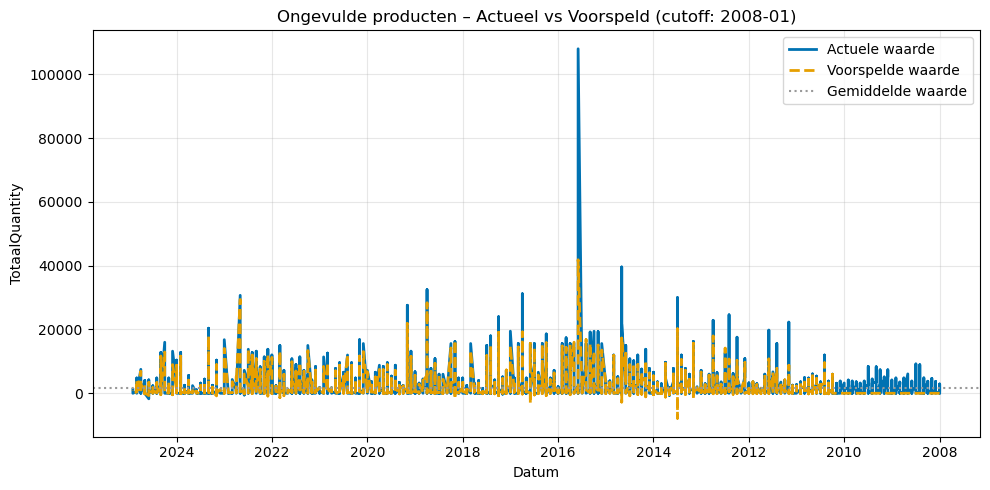

Producten op melkbasis: Train R²=0.910, Test R²=0.694, Train MAE=1131.6, Test MAE=2107.2


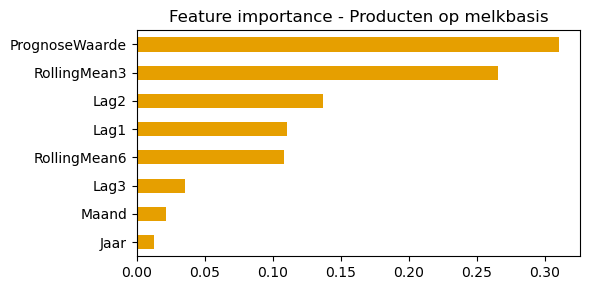

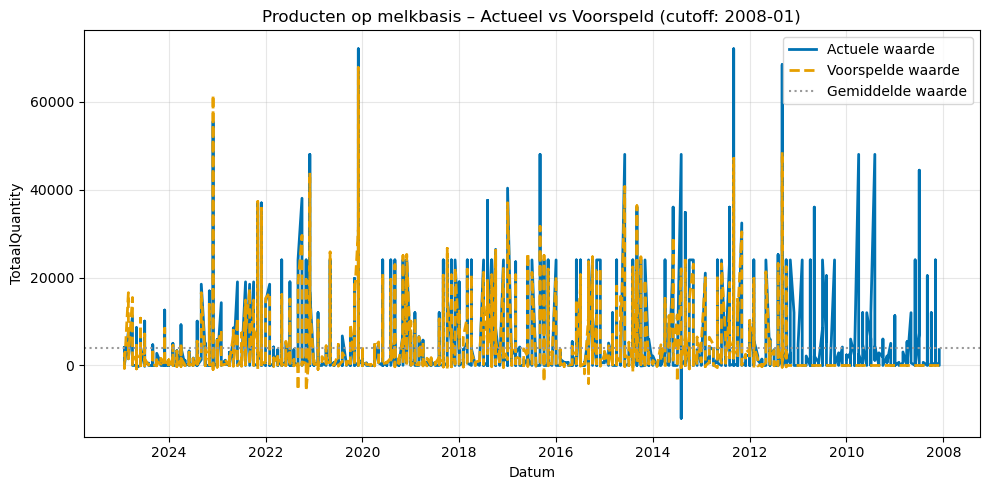

Suikervrij: Train R²=0.329, Test R²=0.712, Train MAE=791.8, Test MAE=780.0


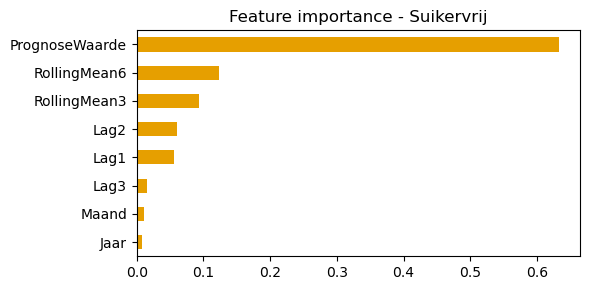

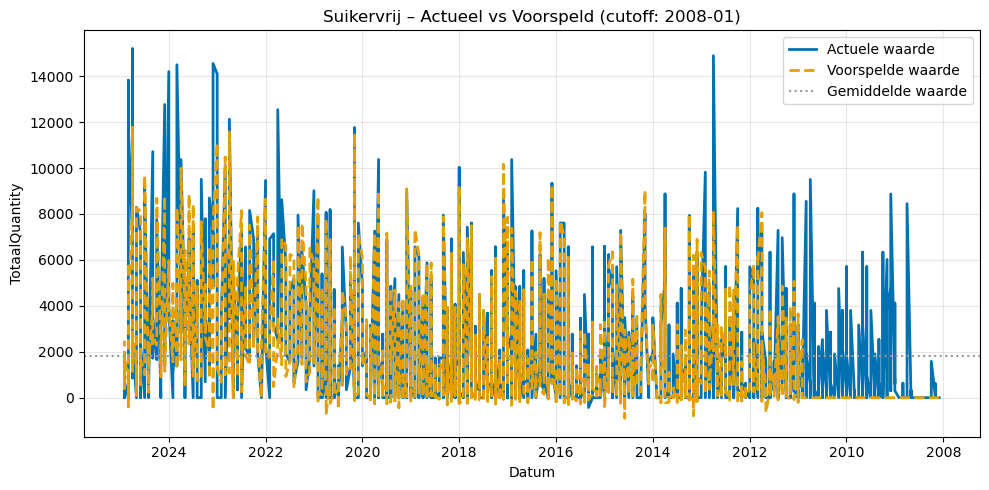


=== Modelresultaten per productgroep ===
                GroepNaam CutoffDatum  AantalRijen  R2_train   R2_test  \
1       Gevulde producten  2016-01-01         3389  0.697851  0.827017   
2          Keelverzorgers  2008-01-01         4675  0.790743  0.807506   
0                       -  2016-01-01         2532  0.846470  0.759499   
5     Ongevulde producten  2008-01-01         3172  0.809496  0.743670   
7              Suikervrij  2008-01-01          884  0.329158  0.711555   
4         Napoleon kogels  2016-01-01         4472  0.722792  0.704860   
6  Producten op melkbasis  2008-01-01         1262  0.910181  0.693895   
3                 Lolly's  2008-01-01         1571  0.791978  0.689095   

     MAE_train     MAE_test  \
1   832.710712   872.199313   
2  1513.817284  1688.881458   
0   539.610367   982.338178   
5   556.975154   667.453062   
7   791.805179   779.962474   
4   661.787564   938.646042   
6  1131.646728  2107.206063   
3   307.495796   494.513933   

           

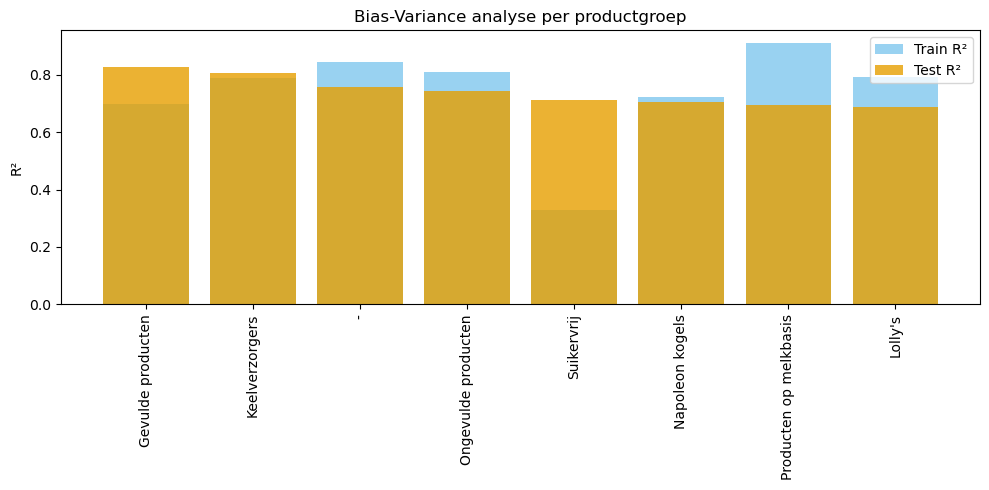

In [3]:
#-----------------------
# 0. Data inladen
#-----------------------
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[Napoleon_All]"
dataModel = pd.read_sql_query(query, conn)

#-----------------------
# import libraries
#-----------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
ModelClass = XGBRegressor


# Voor reproduceerbaarheid
np.random.seed(42)

# -----------------------
# 1. Data voorbereiden
# -----------------------
df = dataModel.copy()
df["Datum"] = pd.to_datetime(df["Jaar"].astype(str) + "-" + df["Maand"].astype(str) + "-01")
df = df.sort_values(["GroepNaam", "Datum"])
df = df[~df["GroepNaam"].isin(["Diverse producten", "Lickbits", "suikervrij"])]

groepen = df["GroepNaam"].unique()
print(f"Analyseren van {len(groepen)} productgroepen (zonder Diverse producten en Lickbits).")

# -----------------------
# 2. Cutoff instellen per groep
# -----------------------
cutoffs = {
    # Groepen die BETER presteren vanaf 2016
    "Gevulde producten": "2016-01-01",
    "Napoleon kogels": "2016-01-01",
    "-": "2016-01-01",
    # Alle overige groepen krijgen data vanaf 2008
    "default": "2008-01-01"
}

# -----------------------
# 3. TimeSeriesSplit instellen
# -----------------------
resultaten = []
tscv = TimeSeriesSplit(n_splits=5)

# -----------------------
# 4. Modeltraining per groep
# -----------------------
for groep in groepen:
    sub = df[df["GroepNaam"] == groep].copy()

    # Cutoff toepassen
    cutoff_datum = pd.to_datetime(cutoffs.get(groep, cutoffs["default"]))
    sub = sub[sub["Datum"] >= cutoff_datum]

    n_rows = len(sub)
    if n_rows < 30:
        continue

    # Feature engineering
    sub = sub.sort_values("Datum")
    sub["Lag1"] = sub["TotaalQuantity"].shift(1)
    sub["Lag2"] = sub["TotaalQuantity"].shift(2)
    sub["Lag3"] = sub["TotaalQuantity"].shift(3)
    sub["RollingMean3"] = sub["TotaalQuantity"].rolling(3).mean()
    sub["RollingMean6"] = sub["TotaalQuantity"].rolling(6).mean()
    sub["MonthSin"] = np.sin(2 * np.pi * sub["Maand"] / 12)
    sub["MonthCos"] = np.cos(2 * np.pi * sub["Maand"] / 12)
    sub = sub.dropna()

    X = sub[[
        "PrognoseWaarde", "Jaar", "Maand", 
        "Lag1", "Lag2", "Lag3", 
        "RollingMean3", "RollingMean6",
    ]]
    y = sub["TotaalQuantity"].astype(float)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # -----------------------
    # 5. Hyperparameter tuning
    # -----------------------
    param_distributions = {
        "n_estimators": [200, 400, 600, 800],
        "max_depth": [2, 3, 4, 5],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 1, 5, 10, 20],
    }

    model_search = RandomizedSearchCV(
        ModelClass(random_state=42),
        param_distributions,
        n_iter=10,
        scoring="r2",
        cv=tscv,
        n_jobs=-1,
        verbose=0
    )
    model_search.fit(X_scaled, y)
    best_model = model_search.best_estimator_

    # -----------------------
    # 6. Evaluatie (train/test)
    # -----------------------
    preds_test = np.zeros(len(y))
    preds_train = np.zeros(len(y))

    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        best_model.fit(X_train, y_train)
        preds_train[train_idx] = best_model.predict(X_train)
        preds_test[test_idx] = best_model.predict(X_test)

    mae_train = mean_absolute_error(y, preds_train)
    rmse_train = root_mean_squared_error(y, preds_train)
    r2_train = r2_score(y, preds_train)

    mae_test = mean_absolute_error(y, preds_test)
    rmse_test = root_mean_squared_error(y, preds_test)
    r2_test = r2_score(y, preds_test)

    print(f"{groep}: Train R²={r2_train:.3f}, Test R²={r2_test:.3f}, "
          f"Train MAE={mae_train:.1f}, Test MAE={mae_test:.1f}")

    resultaten.append({
        "GroepNaam": groep,
        "AantalRijen": n_rows,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "R2_train": r2_train,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "R2_test": r2_test,
        "BesteParams": model_search.best_params_,
        "CutoffDatum": cutoff_datum.strftime("%Y-%m-%d")
    })

    # -----------------------
    # 7. Feature importance plot
    # -----------------------
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    plt.figure(figsize=(6,3))
    importances.sort_values(ascending=True).plot.barh(color="#E69F00")
    plt.title(f"Feature importance - {groep}")
    plt.tight_layout()
    plt.show()
    
    # -----------------------
    # 8. Plot: Actueel vs voorspeld
    # -----------------------
    sub["Voorspelling"] = preds_test
    plt.figure(figsize=(10,5))
    plt.plot(sub["Datum"], sub["TotaalQuantity"], label="Actuele waarde", color="#0072B2", linewidth=2)
    plt.plot(sub["Datum"], sub["Voorspelling"], label="Voorspelde waarde", color="#E69F00", linestyle="--", linewidth=2)
    plt.axhline(sub["TotaalQuantity"].mean(), color="#999999", linestyle=":", linewidth=1.5, label="Gemiddelde waarde")
    plt.title(f"{groep} – Actueel vs Voorspeld (cutoff: {cutoff_datum.strftime('%Y-%m')})")
    plt.xlabel("Datum")
    plt.ylabel("TotaalQuantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    # Keer de x-as om zodat de lijn grafisch van rechts naar links loopt
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

# -----------------------
# 9. Samenvatting
# -----------------------
result_df = pd.DataFrame(resultaten).sort_values("R2_test", ascending=False)
pd.set_option("display.max_colwidth", None)

print("\n=== Modelresultaten per productgroep ===")
print(result_df[["GroepNaam", "CutoffDatum", "AantalRijen", "R2_train", "R2_test", 
                 "MAE_train", "MAE_test", "BesteParams"]])

# -----------------------
# 10. Plot bias-variance overzicht
# -----------------------
plt.figure(figsize=(10,5))
plt.bar(result_df["GroepNaam"], result_df["R2_train"], alpha=0.6, label="Train R²", color="#56B4E9")
plt.bar(result_df["GroepNaam"], result_df["R2_test"], alpha=0.8, label="Test R²", color="#E69F00")
plt.xticks(rotation=90)
plt.ylabel("R²")
plt.title("Bias-Variance analyse per productgroep")
plt.legend()
plt.tight_layout()
plt.show()